# 06. Horizon Analysis: The Shift from Momentum to Climate
**Project:** Dengue-Cast PH
**Goal:** To understand *how* the model makes decisions differently for short-term vs. long-term forecasts.

### **The Hypothesis**
* **Short Term (1 Week Ahead):** The model should rely heavily on **Momentum** (Recent Cases). "If cases are high today, they will likely be high next week."
* **Long Term (8 Weeks Ahead):** The momentum signal fades. The model should rely more on **Climate Drivers** (Rainfall/Temp) because these determine the *potential* for future outbreaks (Mosquito breeding).

### **Why this matters?**
If the model only uses "Momentum" for 8 weeks out, it is just guessing. If it shifts to "Climate," it proves the AI has learned the biological delay.

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Settings
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Load Data
PROCESSED_DIR = '/kaggle/input/dengue-defensor-features'
INPUT_FILE = os.path.join(PROCESSED_DIR, '02_features.csv')

df = pd.read_csv(INPUT_FILE, index_col='date', parse_dates=True)

print(f"✅ Data Loaded. Shape: {df.shape}")

✅ Data Loaded. Shape: (768, 27)


In [5]:
# --- MULTI-HORIZON LOOP ---
# We will train 3 separate models to predict 1, 4, and 8 weeks into the future.

horizons = [1, 4, 8]
importance_list = []

print("🚀 Starting Multi-Horizon Training...")

for h in horizons:
    print(f"   -> Training for Horizon: {h} Week(s) Ahead...")
    
    # 1. Create Target for this specific horizon
    # We shift the 'cases' column BACKWARDS by h weeks
    # If h=1, row[0] target is cases at row[1]
    target_col = f'target_{h}w'
    df_h = df.copy()
    df_h[target_col] = df_h['cases'].shift(-h)
    
    # 2. Drop NaNs (The last h weeks have no future)
    df_h = df_h.dropna()
    
    # 3. Split Features (X) and Target (y)
    # Note: We DROP the current 'cases' column to force it to rely on Lags/Climate
    X = df_h.drop(columns=['cases', target_col])
    y = df_h[target_col]
    
    # 4. Train XGBoost (Fast & Good for Feature Importance)
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X, y)
    
    # 5. Extract Feature Importance
    fi = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_,
        'Horizon': f'{h} Week(s) Ahead'
    })
    
    importance_list.append(fi)

# Combine all results
df_importance = pd.concat(importance_list)
print("✅ Training Complete.")

🚀 Starting Multi-Horizon Training...
   -> Training for Horizon: 1 Week(s) Ahead...
   -> Training for Horizon: 4 Week(s) Ahead...
   -> Training for Horizon: 8 Week(s) Ahead...
✅ Training Complete.


In [6]:
# --- CATEGORIZATION ---
# Group specific features into broad buckets for easier plotting.

def categorize_feature(name):
    # Momentum = Any feature related to past cases
    if 'cases' in name:
        return 'Momentum (Past Cases)'
    
    # Climate = Rain, Temp, Humidity
    elif 'rain' in name:
        return 'Climate: Rainfall'
    elif 'temp' in name or 'tmean' in name or 'tmax' in name or 'tmin' in name:
        return 'Climate: Temperature'
    elif 'rh' in name:
        return 'Climate: Humidity'
        
    # Seasonality = Month, Week of Year
    elif 'month' in name or 'week' in name or 'quarter' in name:
        return 'Seasonality (Time)'
        
    else:
        return 'Other'

df_importance['Category'] = df_importance['Feature'].apply(categorize_feature)

# Aggregate (Sum) importance by Category and Horizon
df_grouped = df_importance.groupby(['Horizon', 'Category'])['Importance'].sum().reset_index()

# Sort for better plotting order
df_grouped = df_grouped.sort_values(by=['Horizon', 'Importance'], ascending=[True, False])

print("✅ Features Categorized.")
df_grouped.head()

✅ Features Categorized.


,Horizon,Category,Importance
3,1 Week(s) Ahead,Momentum (Past Cases),0.714090
4,1 Week(s) Ahead,Seasonality (Time),0.119177
2,1 Week(s) Ahead,Climate: Temperature,0.094153
0,1 Week(s) Ahead,Climate: Humidity,0.036581
1,1 Week(s) Ahead,Climate: Rainfall,0.036000


✅ Plot saved to: ../images/horizon_analysis.png


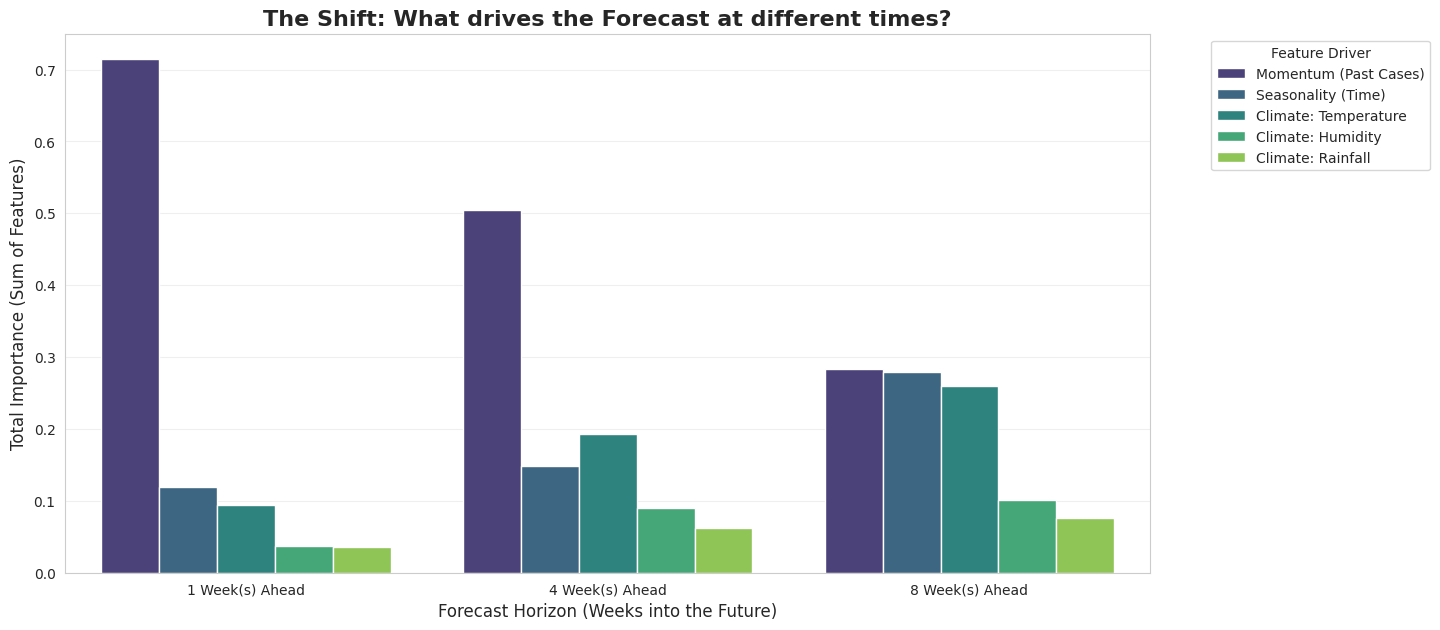

In [7]:
# --- VISUALIZATION ---

plt.figure(figsize=(14, 7))

# Create Bar Plot
sns.barplot(
    data=df_grouped, 
    x='Horizon', 
    y='Importance', 
    hue='Category', 
    palette='viridis'
)

plt.title('The Shift: What drives the Forecast at different times?', fontsize=16, fontweight='bold')
plt.ylabel('Total Importance (Sum of Features)', fontsize=12)
plt.xlabel('Forecast Horizon (Weeks into the Future)', fontsize=12)
plt.legend(title='Feature Driver', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid for readability
plt.grid(axis='y', alpha=0.3)

# Save the plot
output_dir = '../images'
os.makedirs(output_dir, exist_ok=True)
save_path = os.path.join(output_dir, 'horizon_analysis.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

print(f"✅ Plot saved to: {save_path}")
plt.show()